In [50]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

from Utils.customPipelines import *
from Utils.preprocessing import *

from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import plotly.express as px
import colorcet as cc


from itertools import combinations
import warnings

sns.set(font="monospace")
warnings.filterwarnings('ignore')
RANDOM_STATE = 632

# Load Data

In [2]:
df = pd.read_csv('Data/Analyst_Coverage.csv')
print(df.shape)
df

(8676, 9)


,ANALYST,DATE,BROKER,RATING,RECOMMENDATION,TARGET_PRICE,BBTICKER,GICS_SECTOR_NAME,GICS_INDUSTRY_GROUP_NAME
0,Jamrgett,3/5/2020,Beerg,5.0,buy,1.220000e+02,NESN SW Equity,Consumer Staples,"Food, Beverage & Tobacco"
1,Joneeney,3/3/2020,Corch,3.0,equalweight,1.050000e+02,NESN SW Equity,Consumer Staples,"Food, Beverage & Tobacco"
2,MarDeboo,3/2/2020,Jeies,3.0,hold,1.050000e+02,NESN SW Equity,Consumer Staples,"Food, Beverage & Tobacco"
3,Niclberg,3/1/2020,Lirum,3.0,hold,1.070000e+02,NESN SW Equity,Consumer Staples,"Food, Beverage & Tobacco"
4,Antpagna,2/27/2020,ISEVA,5.0,overweight,-2.420000e-14,NESN SW Equity,Consumer Staples,"Food, Beverage & Tobacco"
...,...,...,...,...,...,...,...,...,...
8671,Inghmidt,4/7/2016,Hasse,1.0,sell,-2.420000e-14,LHA GR Equity,Industrials,Transportation
8672,Xavaroen,3/9/2018,Br Co,3.0,neutral,8.800000e+01,BMW3 GR Equity,Consumer Discretionary,Automobiles & Components
8673,FraMaury,4/4/2016,OdBHF,2.0,reduce,8.900000e+01,BMW3 GR Equity,Consumer Discretionary,Automobiles & Components
8674,RenWeber,2/4/2020,Ba AG,3.0,hold,5.000000e+01,UHRN SW Equity,Consumer Discretionary,Consumer Durables & Apparel


# Data Preprocessing

In [3]:
# Drop rows with missing data (Assuming missing RATING means not properly covered by analyst)
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)
print()

# Check for duplicates
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)
print()

# Check Types
print(df.info())

Missing values per column:
 ANALYST                       0
DATE                          0
BROKER                        0
RATING                      239
RECOMMENDATION                0
TARGET_PRICE                  0
BBTICKER                      0
GICS_SECTOR_NAME              0
GICS_INDUSTRY_GROUP_NAME      0
dtype: int64

Number of duplicate rows: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8676 entries, 0 to 8675
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ANALYST                   8676 non-null   object 
 1   DATE                      8676 non-null   object 
 2   BROKER                    8676 non-null   object 
 3   RATING                    8437 non-null   float64
 4   RECOMMENDATION            8676 non-null   object 
 5   TARGET_PRICE              8676 non-null   float64
 6   BBTICKER                  8676 non-null   object 
 7   GICS_SECTOR_NAME          8676 non-

In [4]:
# Impute NaN values for ratings with mean ratings per industry
df_mean_rating = df[["GICS_SECTOR_NAME", "RATING"]].dropna().groupby(["GICS_SECTOR_NAME"], as_index=False).mean()
df_imputed = df[df["RATING"].isna()].copy()
df_imputed = df_imputed.drop(columns=["RATING"]).merge(df_mean_rating, on=["GICS_SECTOR_NAME"])
df_clean = pd.concat([df.dropna(), df_imputed])

print(df_clean.shape)
df_clean.sample(7)

(8676, 9)


,ANALYST,DATE,BROKER,RATING,RECOMMENDATION,TARGET_PRICE,BBTICKER,GICS_SECTOR_NAME,GICS_INDUSTRY_GROUP_NAME
3102,Thooudry,2/14/2020,Br Co,3.0,neutral,2.250000e+01,VIV FP Equity,Communication Services,Media & Entertainment
4697,Wimpadia,2/21/2020,Beein,5.0,outperform,9.800000e+01,UCB BB Equity,Health Care,"Pharmaceuticals, Biotechnology"
1057,Valtaldy,3/2/2020,DaDay,5.0,buy,2.211000e+01,DTE GR Equity,Communication Services,Telecommunication Services
5368,Antpagna,10/4/2019,ISEVA,5.0,overweight,-2.420000e-14,GFC FP Equity,Real Estate,Real Estate
2652,Agnilela,2/3/2020,Nodea,5.0,buy,2.000000e+02,VOLVB SS Equity,Industrials,Capital Goods
4110,Valtaldy,3/2/2020,DaDay,1.0,sell,5.780000e+00,DBK GR Equity,Financials,Diversified Financials
4673,Jeatschy,2/12/2020,Ba AG,5.0,buy,3.000000e+03,SGSN SW Equity,Industrials,Commercial & Professional Serv


# Data Analysis

## 1. Which company has the higher analyst coverage?

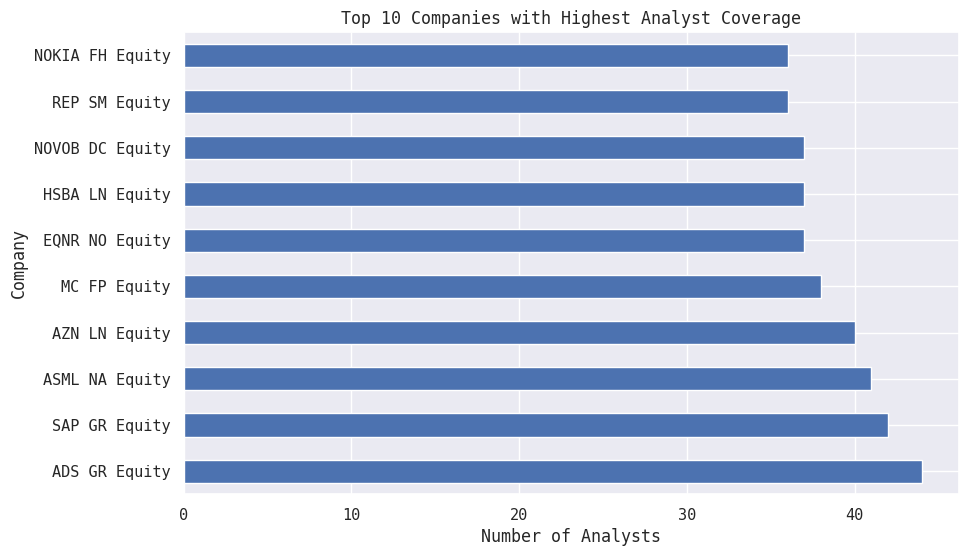

The company with the highest analyst coverage is 'ADS GR Equity' with 44 analysts covering it.


In [5]:
# Calculate the analyst coverage for each company
df_coverage = df_clean[['BBTICKER', 'ANALYST']].copy()
df_coverage = df_coverage.drop_duplicates()
company_coverage = df_coverage['BBTICKER'].value_counts()

# Plot the top 10 companies with the highest analyst coverage
top_10_company_coverage = company_coverage.head(10)

plt.figure(figsize=(10, 6))
top_10_company_coverage.plot(kind='barh')
plt.title('Top 10 Companies with Highest Analyst Coverage')
plt.ylabel('Company')
plt.xlabel('Number of Analysts')
plt.show()

# Find the company with the highest analyst coverage
most_covered_company = company_coverage.idxmax()
most_covered_company_coverage = company_coverage.max()

print(f"The company with the highest analyst coverage is '{most_covered_company}' with {most_covered_company_coverage} analysts covering it.")


## 2. Which analyst covers the most companies?

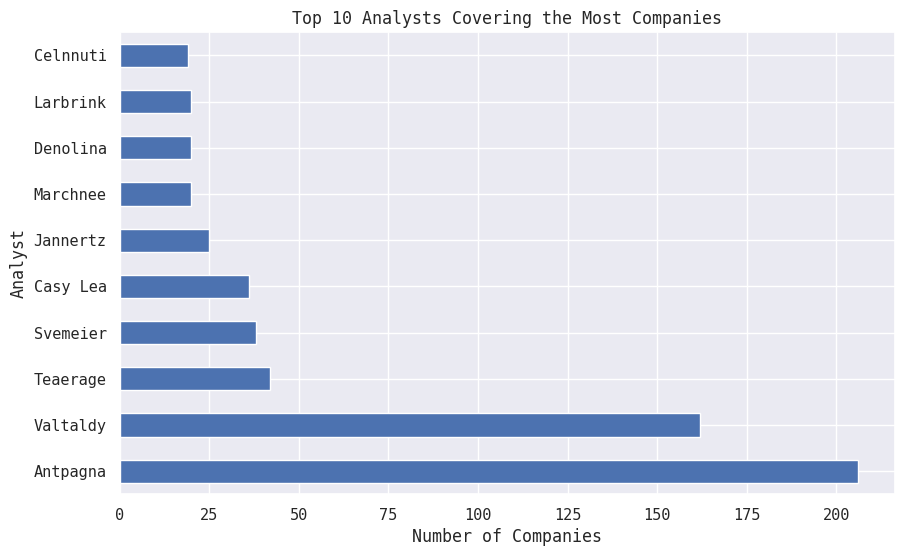

The analyst who covers the most companies is 'Antpagna' covering 206 different companies.


In [6]:
# Calculate the number of companies each analyst covers
# analyst_coverage = df.groupby('ANALYST')['BBTICKER'].nunique()
analyst_coverage = df_coverage['ANALYST'].value_counts()

# Plot the top 10 analysts covering the most companies
# top_10_analyst_coverage = analyst_coverage.sort_values(ascending=False).head(10)
top_10_analyst_coverage = analyst_coverage.head(10)

plt.figure(figsize=(10, 6))
top_10_analyst_coverage.plot(kind='barh')

plt.title('Top 10 Analysts Covering the Most Companies')
plt.ylabel('Analyst')
plt.xlabel('Number of Companies')
plt.show()

# Find the analyst covering the most companies
most_companies_analyst = analyst_coverage.idxmax()
most_companies_coverage = analyst_coverage.max()

print(f"The analyst who covers the most companies is '{most_companies_analyst}' covering {most_companies_coverage} different companies.")

## 3. Similarity Matrix
https://medium.com/analytics-vidhya/similarity-measures-for-categorical-data-d83a1812bbe9

Based on how analysts organize themselves into covering companies,
### 3a. Could you model the similarity or conversely, the distance matrix between the companies based on this analyst co-coverage


Shape of the similarity matrix: (206, 206)


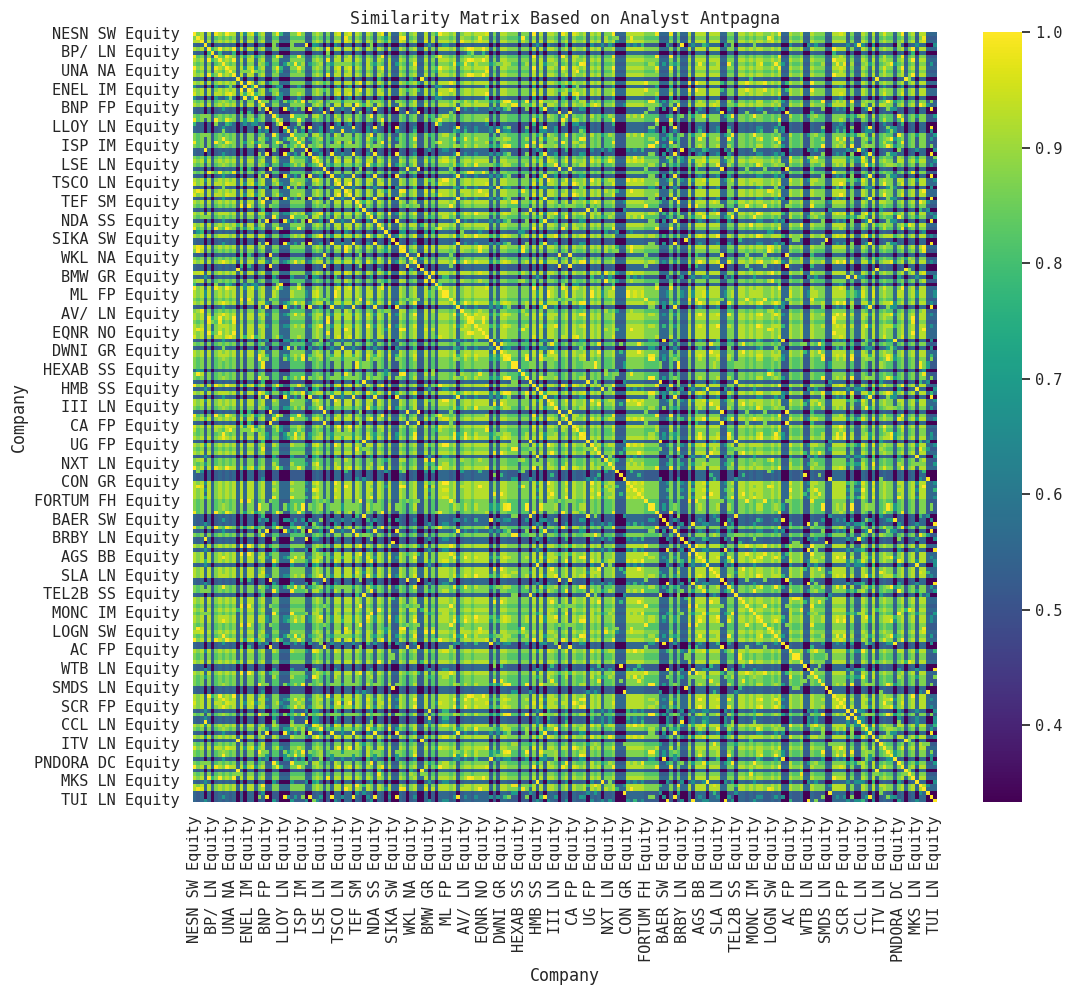

In [34]:
categorical_features_ordinal = []
categorical_features_one_hot = ['GICS_SECTOR_NAME', 'GICS_INDUSTRY_GROUP_NAME', 'BROKER']
numerical_features = ['RATING']
clean_pipeline = get_pipeline_clean_encode_only(categorical_features_one_hot, categorical_features_ordinal, numerical_features)

# Dataset for analyst Antpagna with removed duplicates
df_analyst_antpaga = df_clean[df_clean["ANALYST"] == "Antpagna"].drop_duplicates(subset=['BBTICKER']).reset_index(drop=True)

# Similarity matrix for Antpage
df_preprocessed_antaga = clean_pipeline.fit_transform(df_analyst_antpaga.copy())
df_analyst_antpaga_cols = df_analyst_antpaga["BBTICKER"].tolist().copy()
df_preprocessed_antaga_sim = pd.DataFrame(data = cosine_similarity(df_preprocessed_antaga, df_preprocessed_antaga),  index = df_analyst_antpaga_cols, columns = df_analyst_antpaga_cols)

print("Shape of the similarity matrix:", df_preprocessed_antaga_sim.shape)

plt.figure(figsize=(12, 10))
sns.heatmap(df_preprocessed_antaga_sim, cmap='viridis')
plt.title('Similarity Matrix Based on Analyst Antpagna')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()

Shape of the distance matrix: (206, 206)


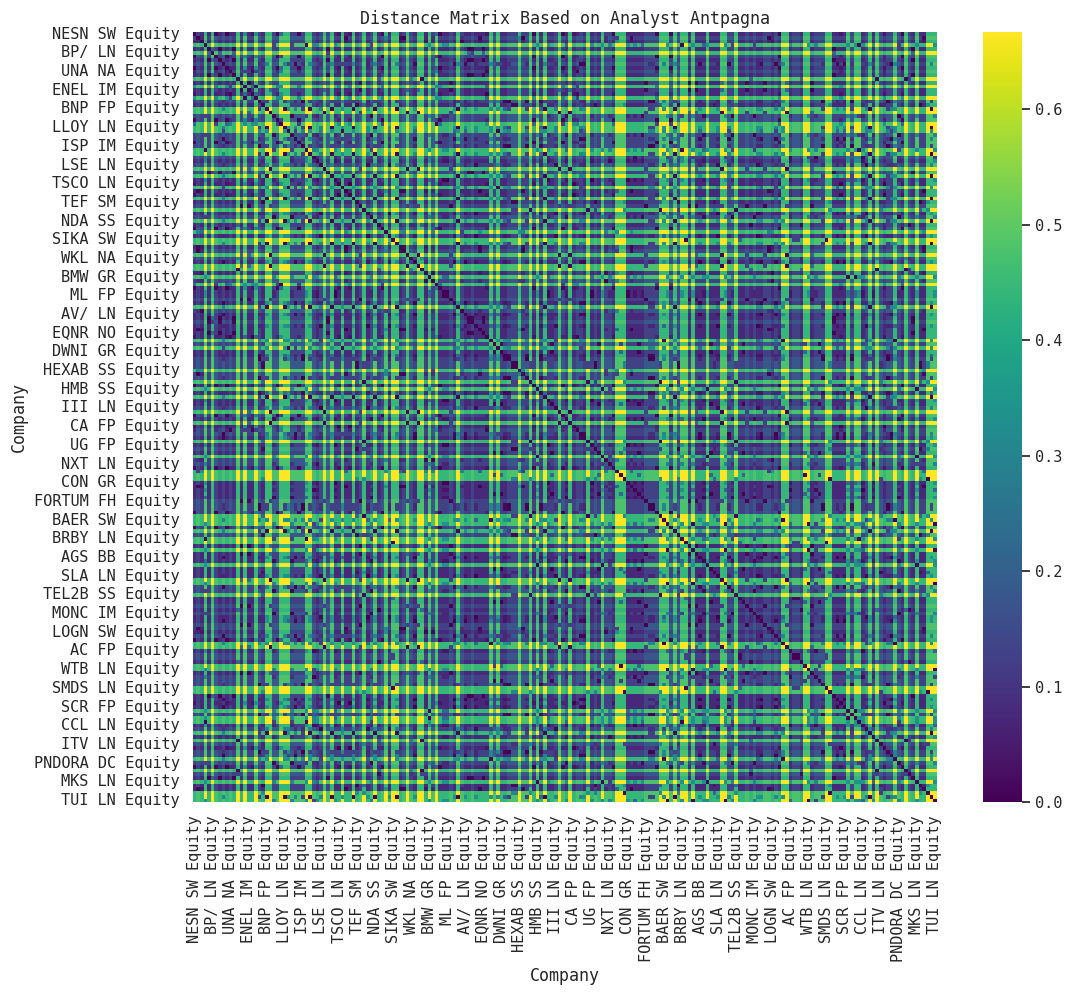

In [8]:
# Distance matrix for Antpaga
df_preprocessed_antaga_dist = 1 - df_preprocessed_antaga_sim

print("Shape of the distance matrix:", df_preprocessed_antaga_dist.shape)

plt.figure(figsize=(12, 10))
sns.heatmap(df_preprocessed_antaga_dist, cmap='viridis')
plt.title('Distance Matrix Based on Analyst Antpagna')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()

### 3b. How would the results change if you were to restrict the dataset to only analysts having companies covered within 1s.d. of the distribution found in Qn. 2?

Shape of the similarity matrix: (360, 360)


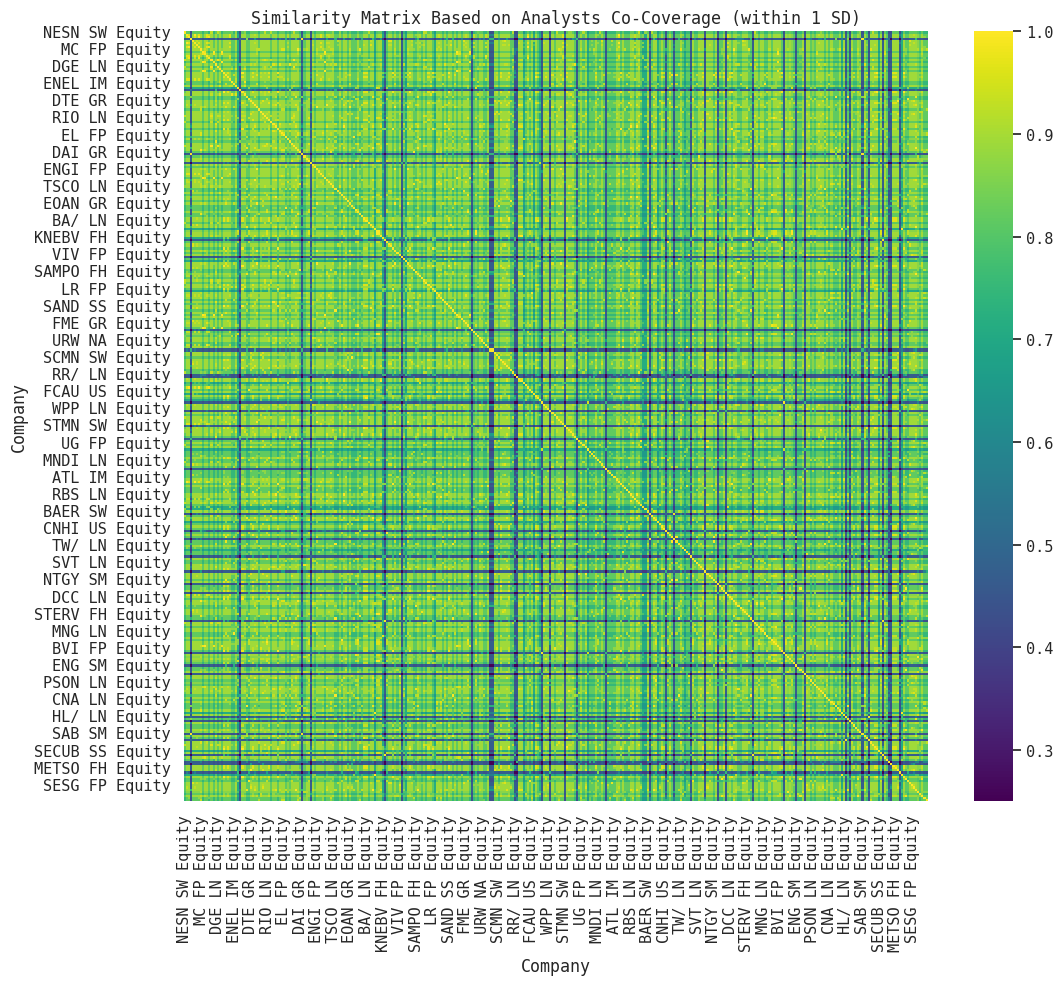

In [65]:
# Calculate the mean and standard deviation of the number of companies covered by each analyst
mean_coverage = analyst_coverage.mean()
std_dev_coverage = analyst_coverage.std()

# Filter analysts who cover companies within 1 standard deviation of the mean
filtered_analysts = analyst_coverage[(analyst_coverage >= mean_coverage - std_dev_coverage) &
                                     (analyst_coverage <= mean_coverage + std_dev_coverage)].index
df_filtered = df_clean[df_clean['ANALYST'].isin(filtered_analysts)].drop_duplicates(subset=['BBTICKER']).reset_index(drop=True)

# Similarity matrix based on analyst co coverage (within 1 SD)
df_preprocessed_filtered = clean_pipeline.fit_transform(df_filtered)
df_filtered_cols = df_filtered["BBTICKER"].tolist()
df_preprocessed_filtered_sim = pd.DataFrame(data = cosine_similarity(df_preprocessed_filtered, df_preprocessed_filtered),
                                   index = df_filtered_cols, columns = df_filtered_cols)

print("Shape of the similarity matrix:", df_preprocessed_filtered_sim.shape)

plt.figure(figsize=(12, 10))
sns.heatmap(df_preprocessed_filtered_sim, cmap='viridis')
plt.title('Similarity Matrix Based on Analysts Co-Coverage (within 1 SD)' )
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()


Shape of the distance matrix: (360, 360)


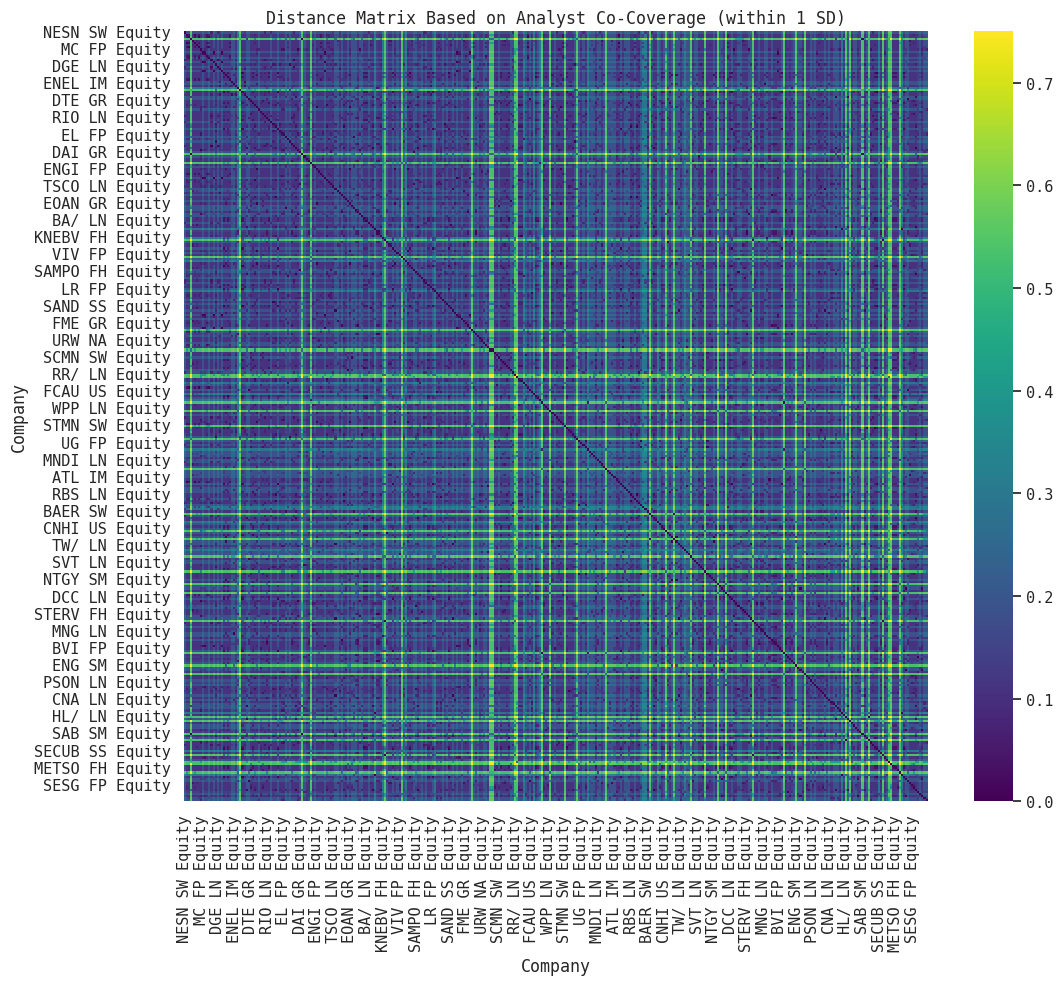

In [66]:
# Distance matrix based on analyst co coverage (within 1 SD)
df_preprocessed_filtered_dist = 1 - df_preprocessed_filtered_sim

print("Shape of the distance matrix:", df_preprocessed_filtered_dist.shape)

plt.figure(figsize=(12, 10))
sns.heatmap(df_preprocessed_filtered_dist, cmap='viridis')
plt.title('Distance Matrix Based on Analyst Co-Coverage (within 1 SD)')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()

### 3c. If further restricted to a smaller subset?

For this example, we further restrict the dataset by only choosing analysts within 0.25 s.d of the mean

Shape of the similarity matrix: (354, 354)


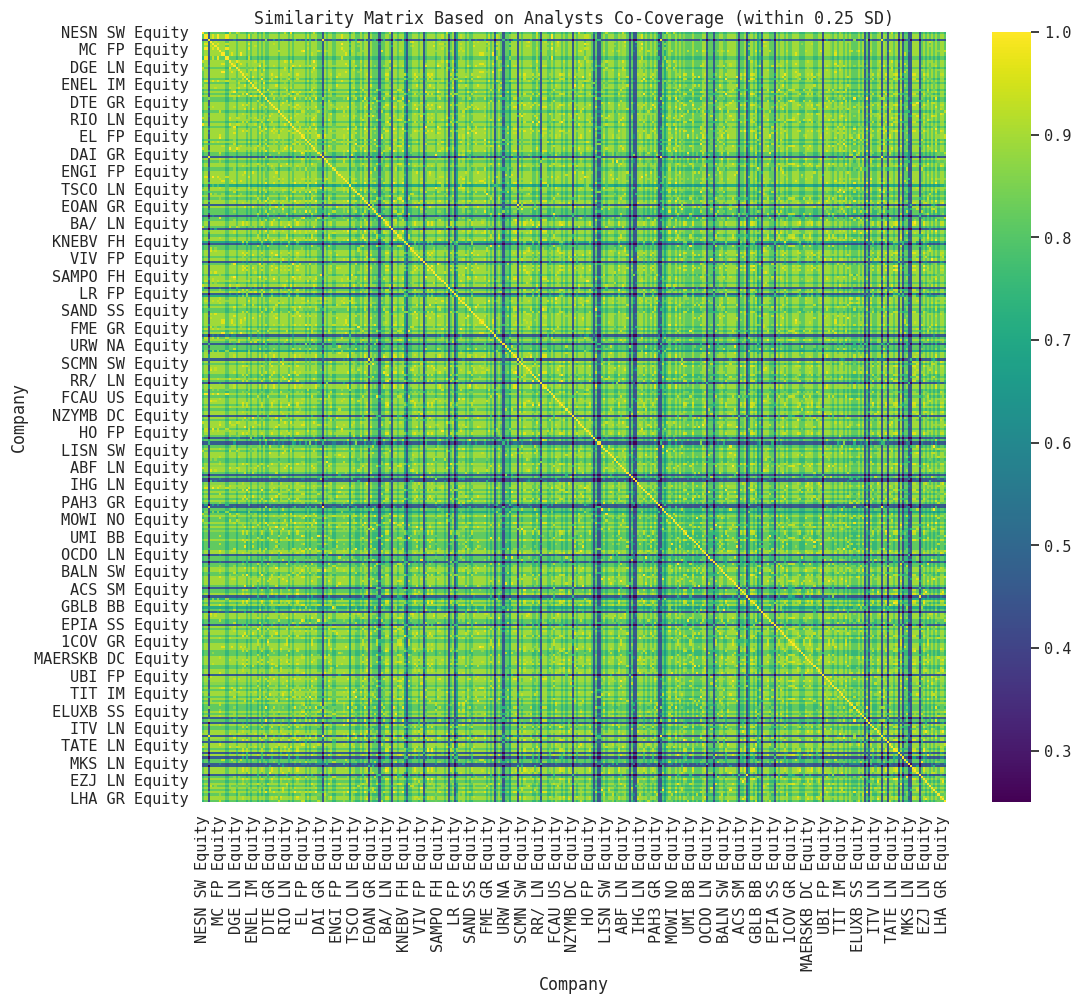

In [71]:
# Calculate the mean and standard deviation of the number of companies covered by each analyst
mean_coverage = analyst_coverage.mean()
std_dev_coverage = analyst_coverage.std()

# Filter analysts who cover companies within 1 standard deviation of the mean
filtered_analysts2 = analyst_coverage[(analyst_coverage >= mean_coverage - std_dev_coverage*0.25) &
                                     (analyst_coverage <= mean_coverage + std_dev_coverage*0.25)].index
df_filtered2 = df_clean[df_clean['ANALYST'].isin(filtered_analysts2)].drop_duplicates(subset=['BBTICKER']).reset_index(drop=True)

# Similarity matrix based on analyst co coverage (within 1 SD)
df_preprocessed_filtered2 = clean_pipeline.fit_transform(df_filtered2)
df_filtered_cols2 = df_filtered2["BBTICKER"].tolist()
df_preprocessed_filtered_sim2 = pd.DataFrame(data = cosine_similarity(df_preprocessed_filtered2, df_preprocessed_filtered2),
                                            index = df_filtered_cols2, columns = df_filtered_cols2)

print("Shape of the similarity matrix:", df_preprocessed_filtered_sim2.shape)

plt.figure(figsize=(12, 10))
sns.heatmap(df_preprocessed_filtered_sim2, cmap='viridis')
plt.title('Similarity Matrix Based on Analysts Co-Coverage (within 0.25 SD)' )
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()

Shape of the distance matrix: (354, 354)


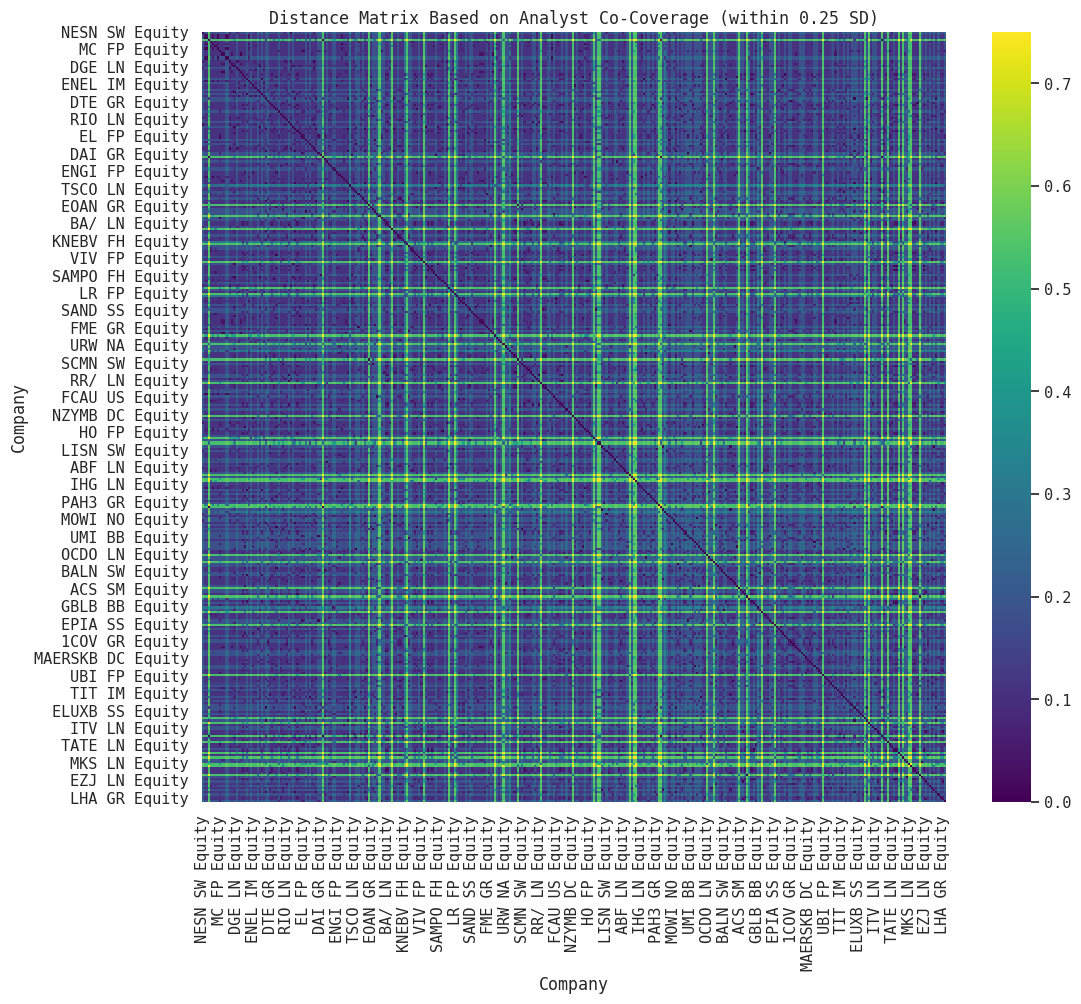

In [72]:
# Distance matrix based on analyst co coverage (within 1 SD)
df_preprocessed_filtered_dist2 = 1 - df_preprocessed_filtered_sim2

print("Shape of the distance matrix:", df_preprocessed_filtered_dist2.shape)

plt.figure(figsize=(12, 10))
sns.heatmap(df_preprocessed_filtered_dist2, cmap='viridis')
plt.title('Distance Matrix Based on Analyst Co-Coverage (within 0.25 SD)')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()

# 4/5/6. Which sectors are the most heterogenous? Which sectors are the most homogenous? What type of companies tend to be outliers in terms of the clusters?
(Look at the clusters formed by industry groups per sector – use t-SNE to visualize)

## 4/5/6a. Using similarity matrix based on analyst with highest coverage

Number of clusters: 30


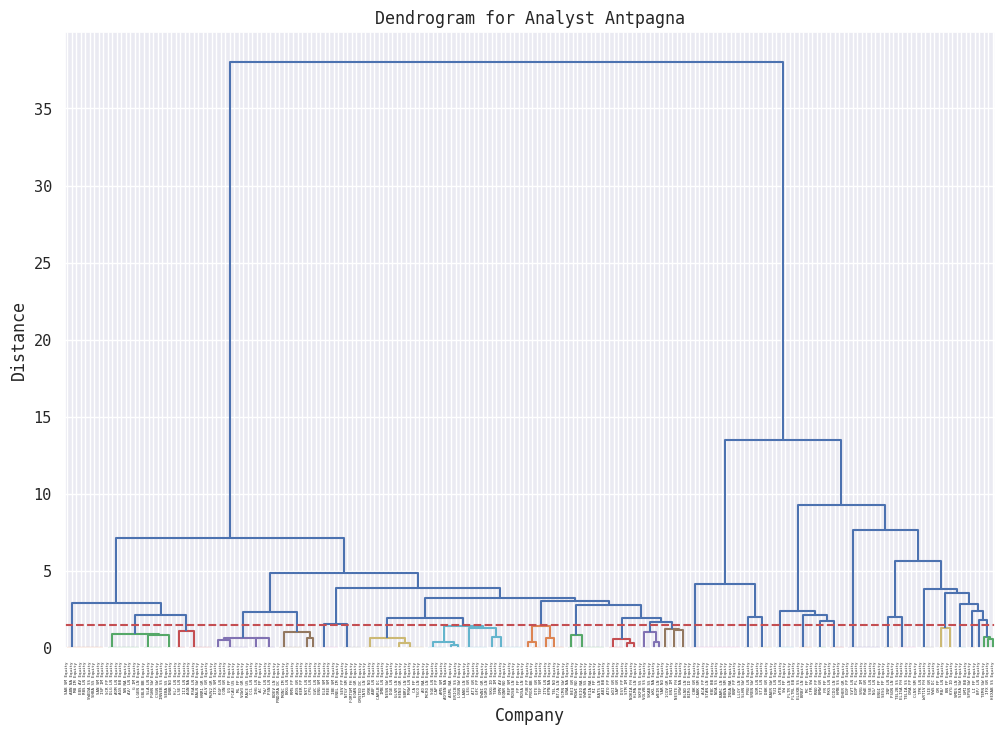

In [15]:
# Hierarchical Clustering for Antpagna based on Distance Matrix in 3a
antaga_link = linkage(df_preprocessed_antaga_dist, method='ward')
threshold = 1.5  # Distance threshold for each cluster
clusters = fcluster(antaga_link, threshold, criterion='distance')
df_analyst_antpaga['Cluster'] = clusters

print(f"Number of clusters: {df_analyst_antpaga['Cluster'].nunique()}")

# Dendrogram for Hierarchical Clustering
plt.figure(figsize=(12, 8))
dendrogram(antaga_link, labels=df_analyst_antpaga_cols, leaf_rotation=90, leaf_font_size=3, color_threshold=threshold)
plt.title('Dendrogram for Analyst Antpagna')
plt.xlabel('Company')
plt.ylabel('Distance')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.show()

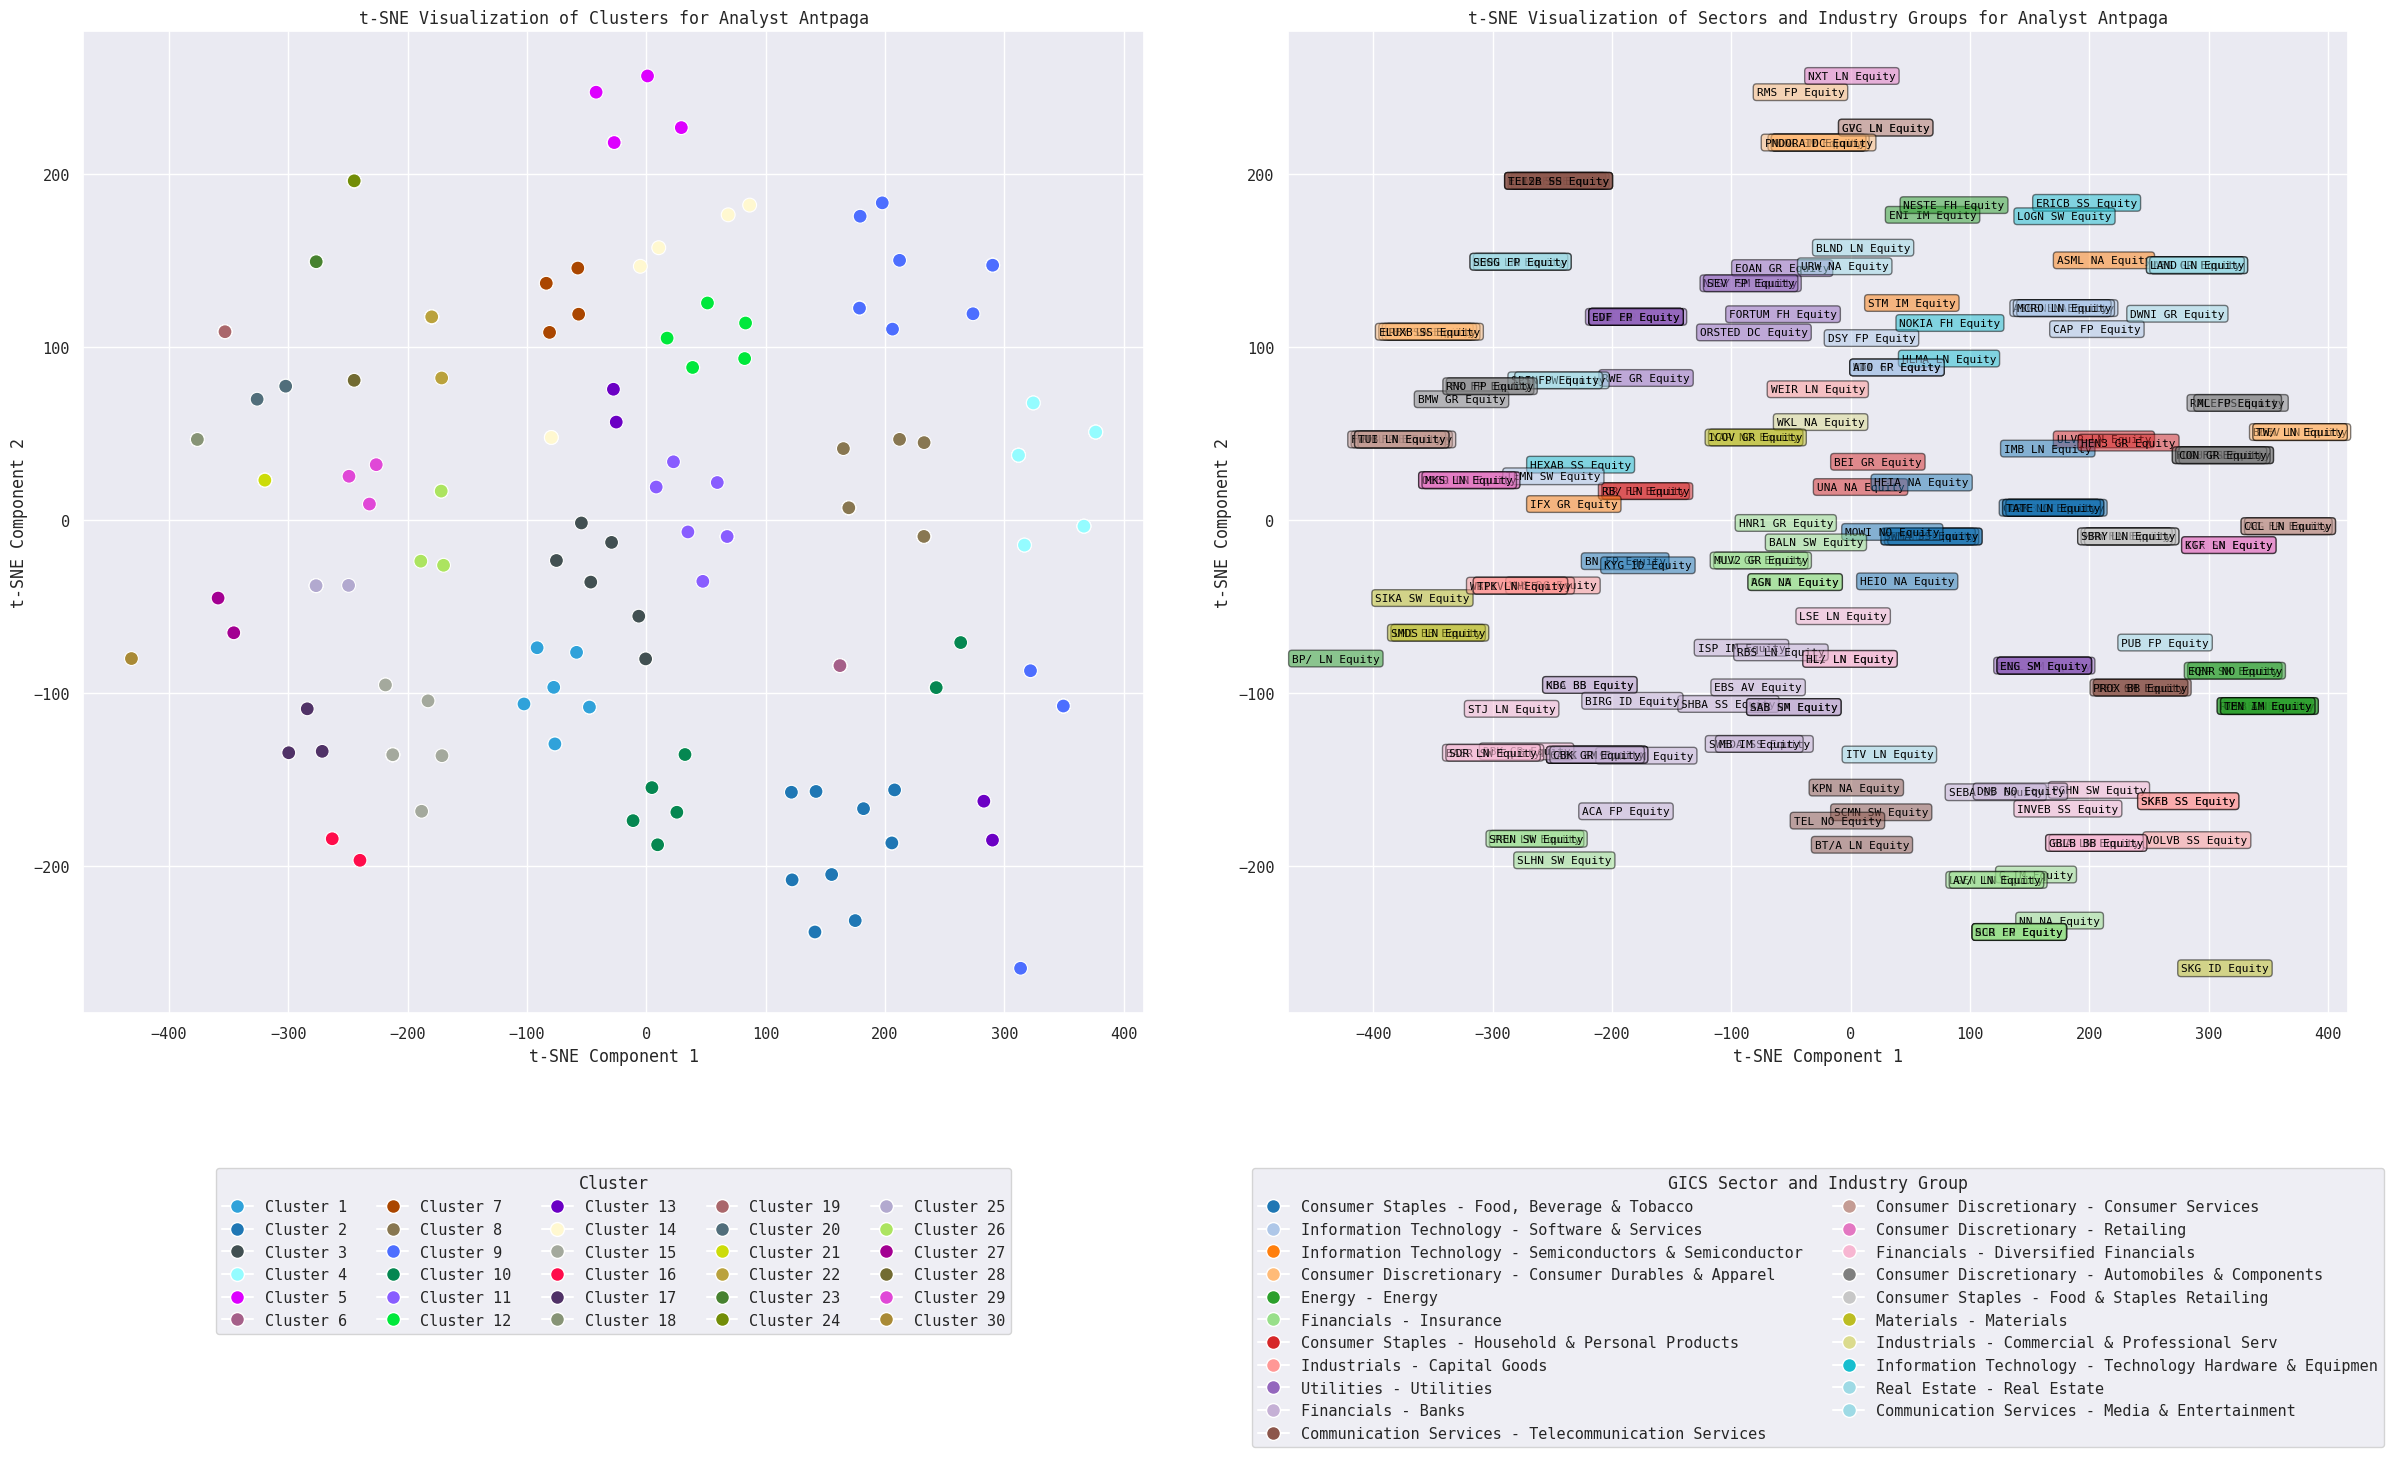

In [16]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
tsne_results = tsne.fit_transform(df_preprocessed_antaga)

# Create a new DataFrame for the t-SNE results with cluster and sector information
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Cluster'] = df_analyst_antpaga['Cluster']
df_tsne['GICS_SECTOR_NAME'] = df_analyst_antpaga['GICS_SECTOR_NAME']
df_tsne['GICS_INDUSTRY_GROUP_NAME'] = df_analyst_antpaga['GICS_INDUSTRY_GROUP_NAME']
df_tsne['Company'] = df_analyst_antpaga['BBTICKER']

fig, axes = plt.subplots(1, 2, figsize=(25, 15))

# Plot t-SNE by clusters
cmap_clusters = plt.get_cmap("cet_glasbey_hv")
num_clusters = df_tsne['Cluster'].nunique()
colors_clusters = cmap_clusters(np.linspace(0, 1, num_clusters))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', palette='cet_glasbey_hv', data=df_tsne, ax=axes[0], legend='full', s=100, edgecolor='w')
axes[0].set_title('t-SNE Visualization of Clusters for Analyst Antpaga')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')

handles_clusters = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_clusters[i], markersize=10, label=f'Cluster {i+1}') for i in range(num_clusters)]
axes[0].legend(handles=handles_clusters, title='Cluster', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

# Plot t-SNE by sectors and industry groups
combined_colormap = plt.get_cmap("tab20")
unique_combinations = df_tsne[['GICS_SECTOR_NAME', 'GICS_INDUSTRY_GROUP_NAME']].drop_duplicates()
color_map_combined = {tuple(comb): combined_colormap(i) for i, comb in enumerate(unique_combinations.itertuples(index=False, name=None))}

for i in range(df_tsne.shape[0]):
    sector_industry_comb = (df_tsne['GICS_SECTOR_NAME'].iloc[i], df_tsne['GICS_INDUSTRY_GROUP_NAME'].iloc[i])
    axes[1].text(
        df_tsne.TSNE1.iloc[i],
        df_tsne.TSNE2.iloc[i],
        df_tsne.Company.iloc[i],
        horizontalalignment='center',
        verticalalignment='center',
        size=8,
        color='black',
        bbox=dict(facecolor=color_map_combined[sector_industry_comb], alpha=0.5, boxstyle='round,pad=0.3', edgecolor='black')
    )

handles_combined = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map_combined[comb], markersize=10, label=f'{comb[0]} - {comb[1]}') for comb in color_map_combined]
axes[1].legend(handles=handles_combined, title='GICS Sector and Industry Group', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

axes[1].scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], alpha=0.0)
axes[1].set_title('t-SNE Visualization of Sectors and Industry Groups for Analyst Antpaga')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

In [17]:
# Analysis of Hierarchical Clustering

# Calculate silhouette score
silhouette_avg = silhouette_score(df_preprocessed_antaga, clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Cluster composition
cluster_analysis = df_analyst_antpaga.groupby('Cluster')[['GICS_SECTOR_NAME', 'GICS_INDUSTRY_GROUP_NAME']].agg(pd.Series.mode).reset_index()

numeric_columns = df_analyst_antpaga.select_dtypes(include=[np.number]).columns.difference(['Cluster'])
cluster_centroids = df_analyst_antpaga.groupby('Cluster')[numeric_columns].mean().reset_index()
df_cluster = pd.merge(cluster_analysis, cluster_centroids, on='Cluster')
df_cluster

Silhouette Score: 0.6525657418626728


,Cluster,GICS_SECTOR_NAME,GICS_INDUSTRY_GROUP_NAME,RATING,TARGET_PRICE
0,1,Financials,Banks,3.000000,-2.420000e-14
1,2,Financials,Insurance,5.000000,-2.420000e-14
2,3,Financials,Insurance,3.000000,-2.420000e-14
3,4,Consumer Discretionary,Automobiles & Components,5.000000,-2.420000e-14
4,5,Consumer Discretionary,Consumer Durables & Apparel,3.000000,-2.420000e-14
5,6,Utilities,Utilities,5.000000,-2.420000e-14
6,7,Utilities,Utilities,3.000000,-2.420000e-14
7,8,Consumer Staples,"Food, Beverage & Tobacco",5.000000,-2.420000e-14
8,9,Information Technology,Energy,5.000000,-2.420000e-14
9,10,Communication Services,Telecommunication Services,3.888889,-2.420000e-14


For companies analysed by Analyst Antpaga, sectors Information Technology, and Industrials are most heterogenous (sectors spread across multiple clusters), and sectors Utilities and Energy are most homogenous (sectors more clustered together). Company SKG ID Equity from sector and group Materials appears to be an outlier.

## 4/5/6b. Using similarity matrix based on analyst co-coverage (within 1 SD)

Number of clusters: 63


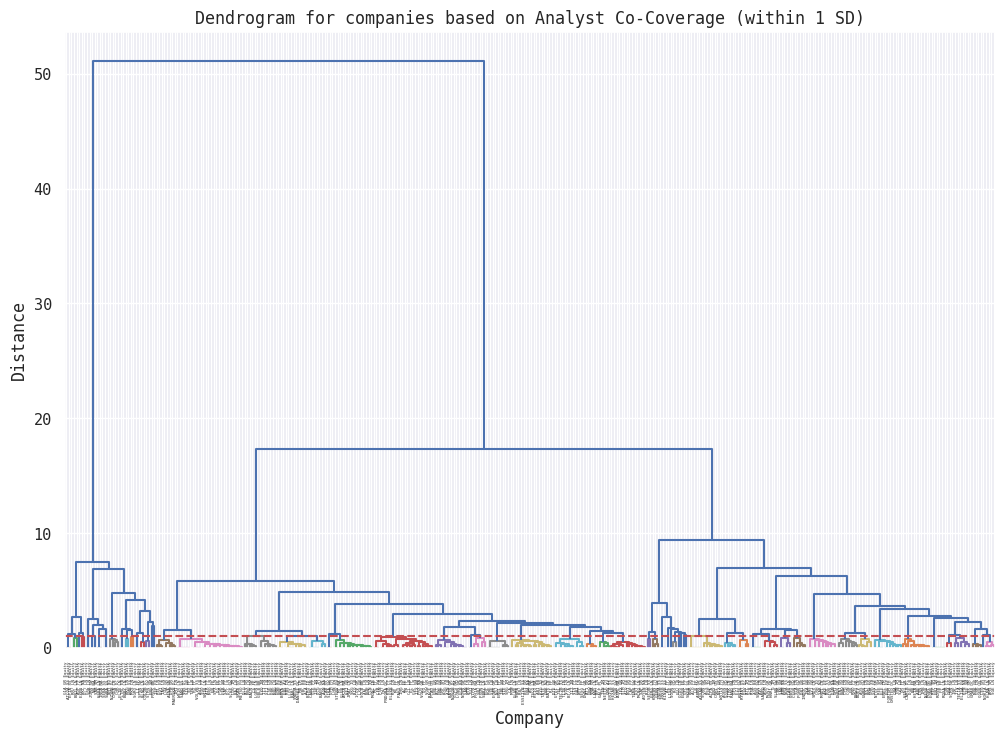

In [93]:
# Hierarchical Clustering for companies based on Distance Matrix in 3b
filtered_link = linkage(df_preprocessed_filtered_dist, method='ward')
threshold = 1  # Distance threshold for each cluster
clusters = fcluster(filtered_link, threshold, criterion='distance')
df_filtered['Cluster'] = clusters

print(f"Number of clusters: {df_filtered['Cluster'].nunique()}")

# Dendrogram for Hierarchical Clustering
plt.figure(figsize=(12, 8))
dendrogram(filtered_link, labels=df_filtered_cols, leaf_rotation=90, leaf_font_size=3, color_threshold=threshold)
plt.title('Dendrogram for companies based on Analyst Co-Coverage (within 1 SD)')
plt.xlabel('Company')
plt.ylabel('Distance')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.show()

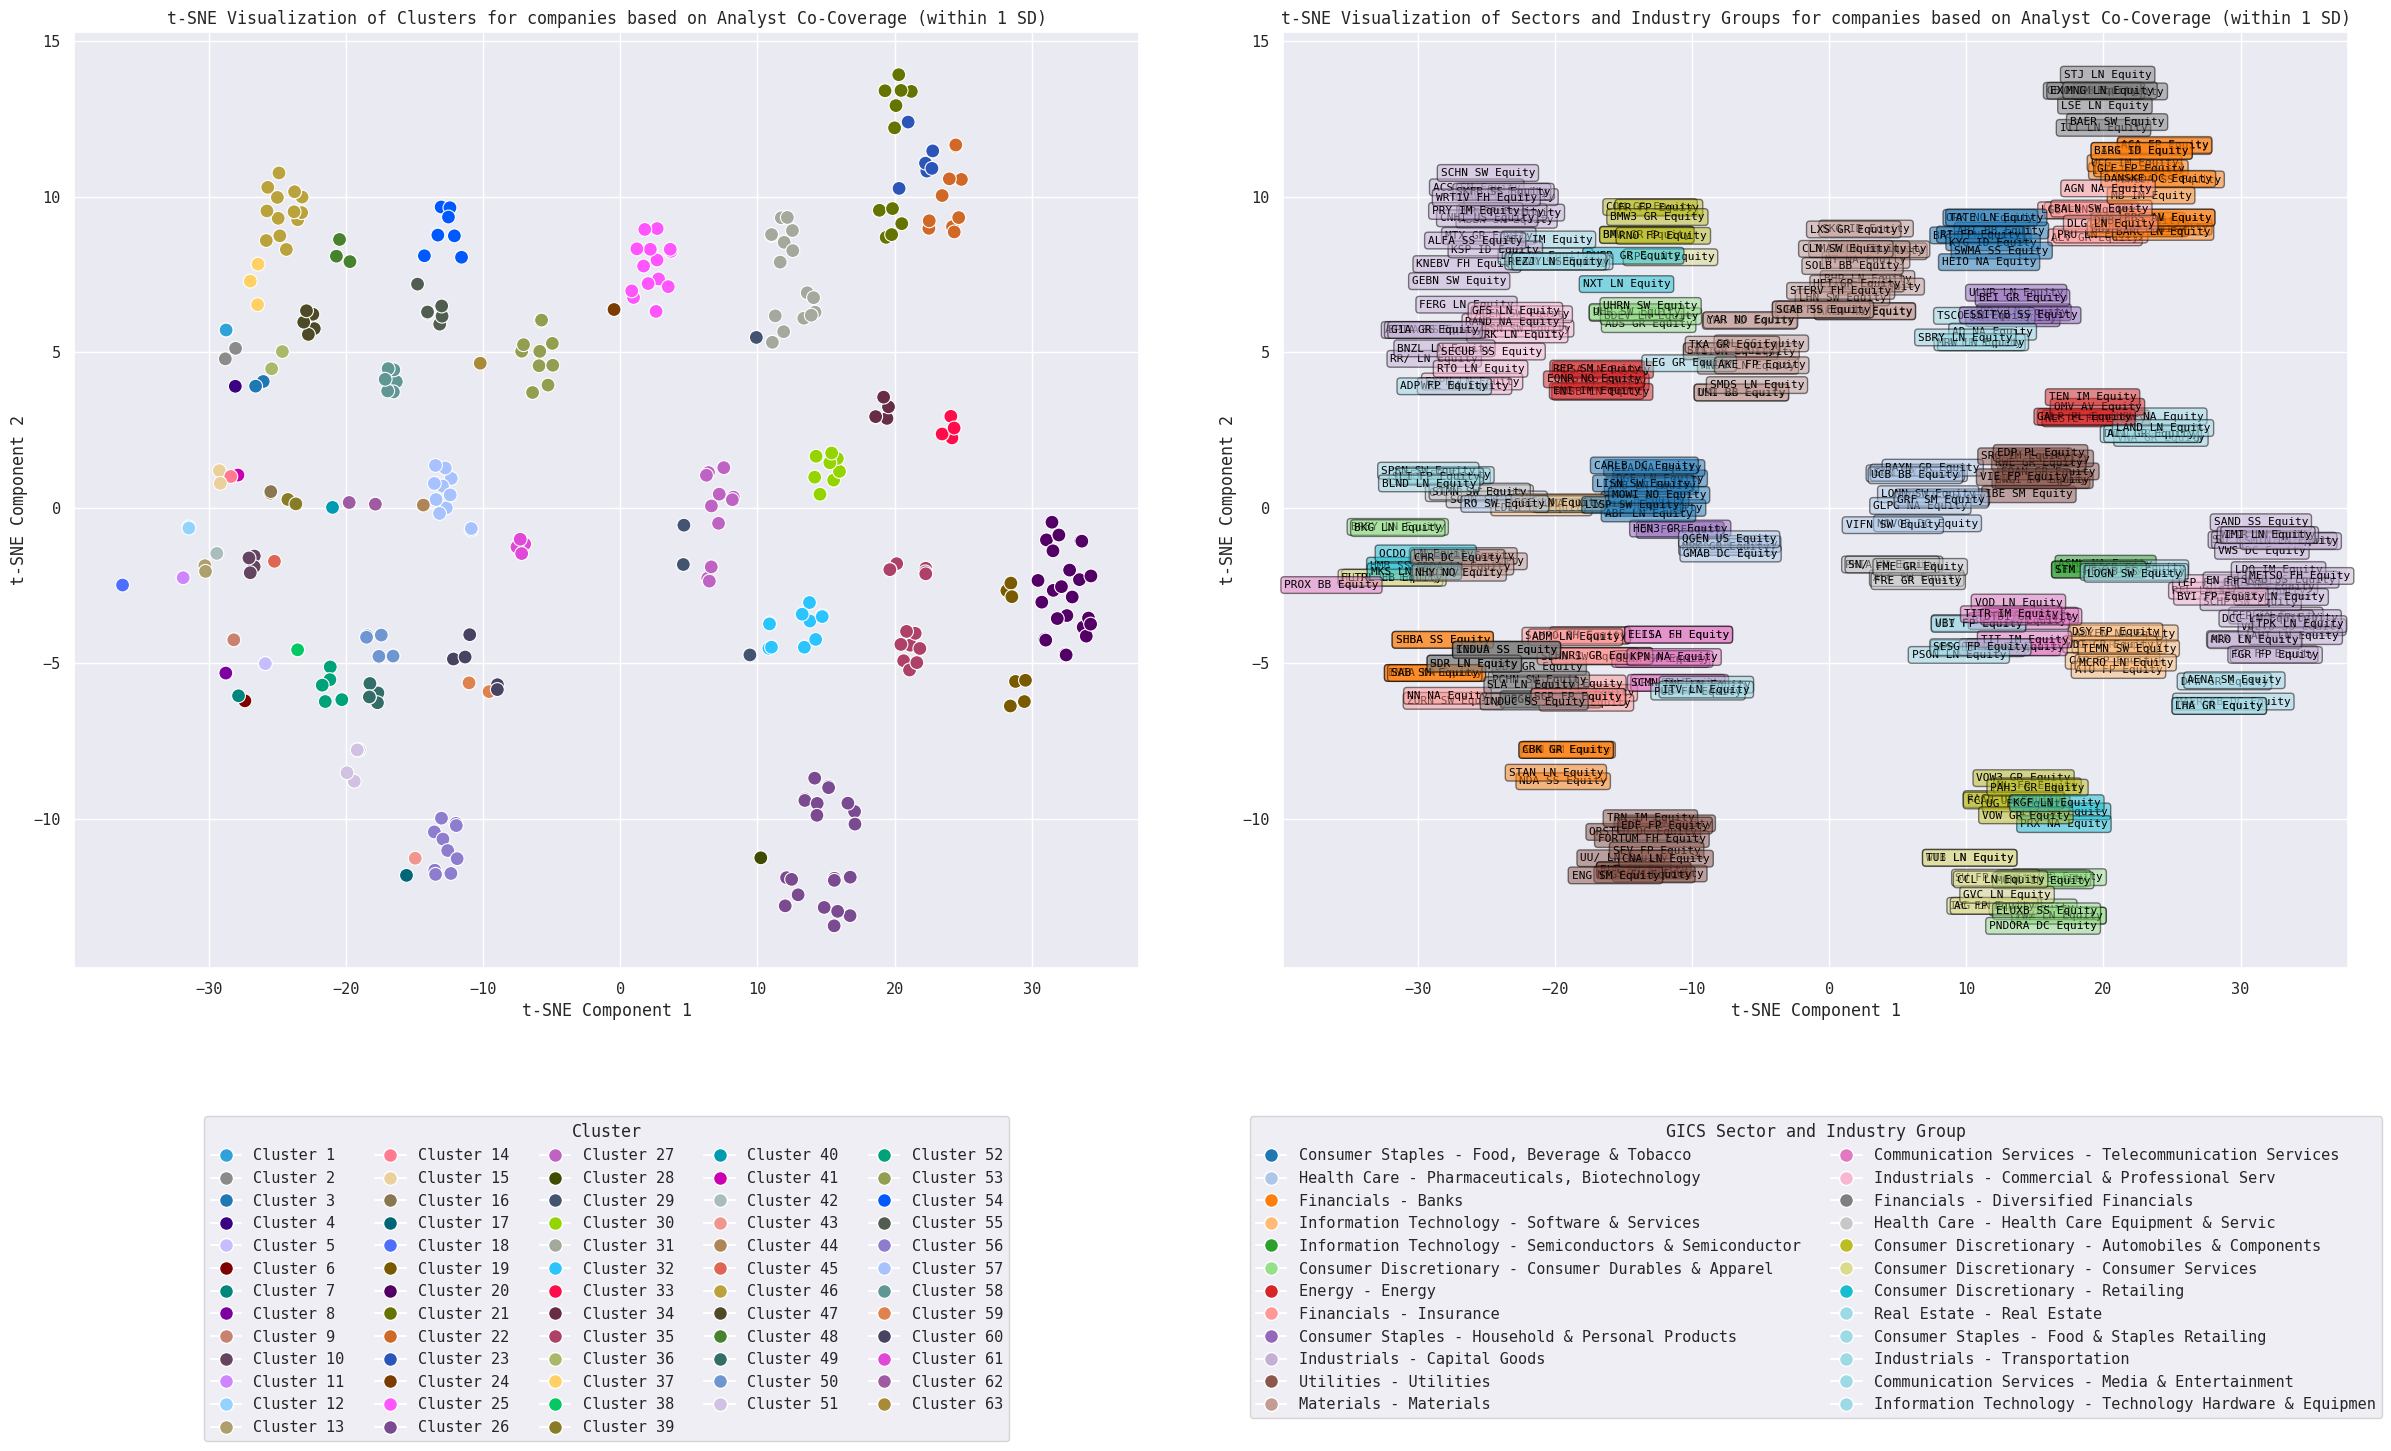

In [94]:
# Perform t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
tsne_results = tsne.fit_transform(df_preprocessed_filtered)

# Create a new DataFrame for the t-SNE results with cluster and sector information
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Cluster'] = df_filtered['Cluster']
df_tsne['GICS_SECTOR_NAME'] = df_filtered['GICS_SECTOR_NAME']
df_tsne['GICS_INDUSTRY_GROUP_NAME'] = df_filtered['GICS_INDUSTRY_GROUP_NAME']
df_tsne['Company'] = df_filtered['BBTICKER']

fig, axes = plt.subplots(1, 2, figsize=(25, 15))

# Plot t-SNE by clusters
cmap_clusters = plt.get_cmap("cet_glasbey_hv")
num_clusters = df_tsne['Cluster'].nunique()
colors_clusters = cmap_clusters(np.linspace(0, 1, num_clusters))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', palette='cet_glasbey_hv', data=df_tsne, ax=axes[0], legend='full', s=100, edgecolor='w')
axes[0].set_title('t-SNE Visualization of Clusters for companies based on Analyst Co-Coverage (within 1 SD)')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')

handles_clusters = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors_clusters[i], markersize=10, label=f'Cluster {i+1}') for i in range(num_clusters)]
axes[0].legend(handles=handles_clusters, title='Cluster', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

# Plot t-SNE by sectors and industry groups
combined_colormap = plt.get_cmap("tab20")
unique_combinations = df_tsne[['GICS_SECTOR_NAME', 'GICS_INDUSTRY_GROUP_NAME']].drop_duplicates()
color_map_combined = {tuple(comb): combined_colormap(i) for i, comb in enumerate(unique_combinations.itertuples(index=False, name=None))}

for i in range(df_tsne.shape[0]):
    sector_industry_comb = (df_tsne['GICS_SECTOR_NAME'].iloc[i], df_tsne['GICS_INDUSTRY_GROUP_NAME'].iloc[i])
    axes[1].text(
        df_tsne.TSNE1.iloc[i],
        df_tsne.TSNE2.iloc[i],
        df_tsne.Company.iloc[i],
        horizontalalignment='center',
        verticalalignment='center',
        size=8,
        color='black',
        bbox=dict(facecolor=color_map_combined[sector_industry_comb], alpha=0.5, boxstyle='round,pad=0.3', edgecolor='black')
    )

handles_combined = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map_combined[comb], markersize=10, label=f'{comb[0]} - {comb[1]}') for comb in color_map_combined]
axes[1].legend(handles=handles_combined, title='GICS Sector and Industry Group', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

axes[1].scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], alpha=0.0)
axes[1].set_title('t-SNE Visualization of Sectors and Industry Groups for companies based on Analyst Co-Coverage (within 1 SD)')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

In [95]:
# Analysis of Hierarchical Clustering

# Calculate silhouette score
silhouette_avg = silhouette_score(df_preprocessed_filtered, clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Cluster composition
cluster_analysis = df_filtered.groupby('Cluster')[['GICS_SECTOR_NAME', 'GICS_INDUSTRY_GROUP_NAME']].agg(pd.Series.mode).reset_index()

numeric_columns = df_filtered.select_dtypes(include=[np.number]).columns.difference(['Cluster'])
cluster_centroids = df_filtered.groupby('Cluster')[numeric_columns].mean().reset_index()
df_cluster = pd.merge(cluster_analysis, cluster_centroids, on='Cluster')
df_cluster

Silhouette Score: 0.30737706739243437


,Cluster,GICS_SECTOR_NAME,GICS_INDUSTRY_GROUP_NAME,RATING,TARGET_PRICE
0,1,Industrials,Capital Goods,1.0,144.166667
1,2,Industrials,Capital Goods,1.0,1149.000000
2,3,Industrials,Commercial & Professional Serv,1.0,1215.950000
3,4,Industrials,Transportation,1.0,126.000000
4,5,Financials,Diversified Financials,1.0,1885.000000
...,...,...,...,...,...
58,59,Communication Services,Telecommunication Services,3.0,193.500000
59,60,Communication Services,Telecommunication Services,3.0,143.617143
60,61,Health Care,"Pharmaceuticals, Biotechnology",3.0,911.625000
61,62,Information Technology,"[Software & Services, Technology Hardware & Equipmen]",3.0,776.525000


For companies analysed xxxx

## 4/5/6c. Using similarity matrix based on analyst co-coverage (within 1 SD)